这里依然使用 MNIST 数据集，同时需要设定一些网络的超参数，方便之后调参改动。

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 读取数据集，TensorFlow 会直接下载数据并且做预处理
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f525e394400>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f52a18e7550>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f525e38f630>)

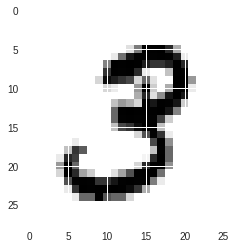

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(mnist.train.images[1].reshape(28,28), cmap=plt.cm.gray_r)

In [ ]:
learning_rate = 0.001  # 学习率
iters = 200 # 迭代次数
batch_size = 64 # mini-batch 所用批量样本数
n_input = 784 # 输入的维度  
n_classes = 10 # 标签的维度  
dropout = 0.75 # Dropout 的概率  

同样，这里需要设定占位符 `x，y`。同时，还需要设定 `dropout` 的占位符。因为 `dropout` 只是在训练时会取 `0-1` 之间的概率值随机断开神经元连接。但是，在识别预测时所有神经元都是连接，此时的 `dropout=1`。所以，这里设定 `dropout` 的占位符方便两个过程改变概率。

In [ ]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

由于之后会不断调用卷积层，池化层和 LRN 的操作，所以在这里我们定义三个函数方便之后的代码书写。

卷积层通过卷积输入和卷积核，`strides` 统一为 `1`，采用 `same padding` 后再加上偏差，并 `relu` 激活得到输出。池化层通过形参 `k` 作为输入，以便于界定过滤器大小和步长大小，采用 `same padding`。归一化统一操作，设定 `bias` 等参数值。

In [ ]:
# 卷积层
def conv2d(name, l_input, w, b):
    conv = tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], padding='SAME')
    z = tf.nn.bias_add(conv, b)
    return tf.nn.relu(z, name=name)

# 最大池化层
def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME', name=name)

# 归一化操作（LRN）
def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

接下来，定义所有的网络参数。这里使用字典结构方便之后调用。初始化时，设定了所有参数的维度大小，参照 AlexNet 的结构。由于 MNIST 的特点，在一些地方做了略微修改。

In [6]:
weights = {
    'wc1': tf.Variable(tf.random_normal([11, 11, 1, 64])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 64, 192])),
    'wc3': tf.Variable(tf.random_normal([3, 3, 192, 384])),
    'wc4': tf.Variable(tf.random_normal([3, 3, 384, 384])),
    'wc5': tf.Variable(tf.random_normal([3, 3, 384, 256])),
    'wd1': tf.Variable(tf.random_normal([4*4*256, 4096])),
    'wd2': tf.Variable(tf.random_normal([4096, 4096])),
    'out': tf.Variable(tf.random_normal([4096, 10]))
}
biases = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([192])),
    'bc3': tf.Variable(tf.random_normal([384])),
    'bc4': tf.Variable(tf.random_normal([384])),
    'bc5': tf.Variable(tf.random_normal([256])),
    'bd1': tf.Variable(tf.random_normal([4096])),
    'bd2': tf.Variable(tf.random_normal([4096])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

Instructions for updating:
Colocations handled automatically by placer.


然后，使用一个函数来定义神经网络结构。AlexNet 采用 5 层卷积后接 2 层全连接层的架构，整体上完全按照 AlexNet 搭建。但是，在部分架构上有所改动，都是为了更适用于手写识别任务。

In [ ]:
# 定义整个网络
def alex_net(_X, _weights, _biases, _dropout):
    # 向量转为矩阵
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1])

    # 第一层卷积
    # 卷积
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # 下采样
    pool1 = max_pool('pool1', conv1, k=2)
    # 归一化
    norm1 = norm('norm1', pool1, lsize=4)

    # 第二层卷积
    # 卷积
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # 下采样
    pool2 = max_pool('pool2', conv2, k=2)
    # 归一化
    norm2 = norm('norm2', pool2, lsize=4)

    # 第三层卷积
    # 卷积
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # 归一化
    norm3 = norm('norm3', conv3, lsize=4)

    # 第四层卷积
    # 卷积
    conv4 = conv2d('conv4', norm3, _weights['wc4'], _biases['bc4'])
    # 归一化
    norm4 = norm('norm4', conv4, lsize=4)

    # 第五层卷积
    # 卷积
    conv5 = conv2d('conv5', norm4, _weights['wc5'], _biases['bc5'])
    # 下采样
    pool5 = max_pool('pool5', conv5, k=2)
    # 归一化
    norm5 = norm('norm5', pool5, lsize=4)

    # 全连接层 1，先把特征图转为向量
    dense1 = tf.reshape(norm5, [-1, _weights['wd1'].get_shape().as_list()[0]])
    dense1 = tf.nn.relu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1')
    dense1 = tf.nn.dropout(dense1, _dropout)

    # 全连接层 2
    dense2 = tf.reshape(dense1, [-1, _weights['wd2'].get_shape().as_list()[0]])
    dense2 = tf.nn.relu(tf.matmul(dense1, _weights['wd2']) + _biases['bd2'], name='fc2')
    dense2 = tf.nn.dropout(dense2, _dropout)

    # 网络输出层
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out

定义交叉熵损失函数以及使用 Adam 优化器。

In [8]:
# 构建模型
pred = alex_net(x, weights, biases, keep_prob)

# 定义损失函数和学习步骤
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 测试网络
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



接下来就是训练过程了。整个训练过程可能持续几分钟，你可以休息下,等一会儿再来看运行结果。

<center><font color="red"><strong>注意：下方代码单元格需要在 GPU 环境中才能执行。</strong></font></center>

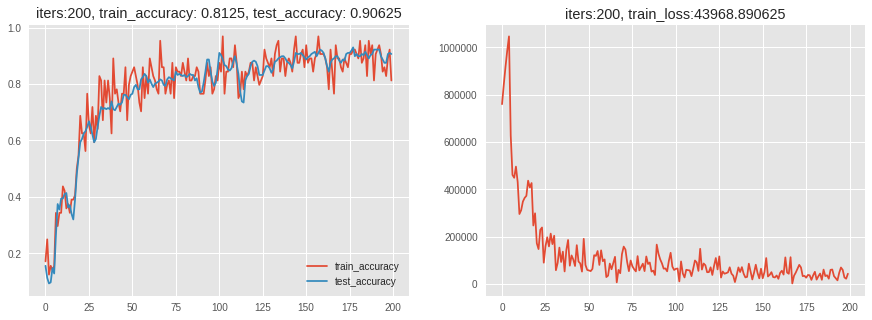

In [9]:
from IPython import display # 引入 display 模块目的方便程序运行展示

# 初始化所有的共享变量
init = tf.global_variables_initializer()

# 开启一个会话
with tf.Session() as sess:
    sess.run(init)
    print('训练开始')
    loss_list = [] # 为了绘图
    train_acc_list = [] # 为了绘图
    test_acc_list = [] # 为了绘图
    for i in range(iters):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # 获取批数据
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        loss, acc_train = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        acc_test = accuracy.eval(feed_dict={x: mnist.test.images[:256], y: mnist.test.labels[:256], keep_prob: 1.})
        
        train_acc_list.append(acc_train)
        test_acc_list.append(acc_test)
        loss_list.append(loss)
        
        # 以下是绘图代码
        display.clear_output(wait=True)
        plt.style.use('ggplot')
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
        
        axes[0].plot(train_acc_list, label='train_accuracy')
        axes[0].plot(test_acc_list, label='test_accuracy')
        axes[0].legend()
        axes[0].set_title("iters:{}, train_accuracy: {}, test_accuracy: {}".format(i+1, acc_train, acc_test))
        
        axes[1].plot(loss_list)
        axes[1].set_title("iters:{}, train_loss:{}".format(i+1, loss))
        plt.show()